# Setup

In [1]:
import os
from datetime import datetime, timezone, timedelta
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import tensorflow as tf
from scipy import stats
from tqdm.notebook import tqdm
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, multilabel_confusion_matrix
from time import perf_counter

# Model formulation

Hierarchical Normal Example Model: New formulation with explicit distributions

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Inv.-Gamma(\alpha_s, \beta_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Inv.-Gamma(\alpha_t, \beta_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

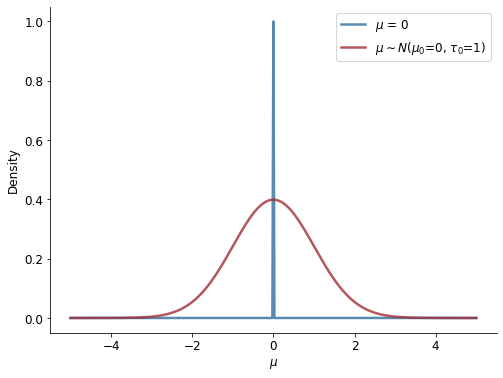

In [2]:
# plot model assumptions about mu

# plot setup
plt.rcParams['font.size'] = 12
colors = ['#2f6e9e', '#9e2f36']
f, ax = plt.subplots(1, 1, figsize=(8, 6))
distri = stats.norm(0, np.sqrt(1))
x = np.linspace(-5, 5, 401)

# generate model pdfs
x_pdf_m0 = [0] * 200 + [1] + [0] * 200
x_pdf_m1 = distri.pdf(x)

# plot pdfs
ax.plot(x, x_pdf_m0, label=r'$\mu$ = {}'.format(0), color=colors[0], lw=2.5, alpha=0.8)
ax.plot(x, x_pdf_m1, label=r'$\mu \sim N(\mu_0$={}, $\tau_0$={})'.format(0, 1), color=colors[1], lw=2.5, alpha=0.8)
ax.set_ylabel('Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('$\\mu$')
ax.legend(fontsize=12)

# Utility functions

In [3]:
# Plotting for training with fixed numbers of clusters and observations

def plot_confusion_matrix(m_true, m_pred, model_names, ax, normalize=True, 
                          cmap=plt.cm.Blues, annotate=True):
    """
    Helper function to print and plot the confusion matrix. 
    Normalization can be applied by setting `normalize=True`.
    """


    # Compute confusion matrix
    cm = confusion_matrix(m_true, m_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=model_names, yticklabels=model_names,
           ylabel='True Model',
           xlabel='Predicted Model')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    if annotate:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    ax.set_title('Confusion Matrix')

    
def plot_calibration_curve(m_true, m_pred, n_bins, ax, title='Calibration'):
    """Helper function to plot calibration curve and ece."""
    
    prob_true, prob_pred = calibration_curve(m_true, m_pred, n_bins=n_bins)
    cal_err = np.mean(np.abs(prob_true - prob_pred))
    ax.plot(prob_true, prob_pred)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.plot(ax.get_xlim(), ax.get_xlim(), '--')
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Confidence')
    ax.text(0.1, 0.9,  'ECE = {0:.3f}'.format(cal_err),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    ax.set_title(title)
    sns.despine(ax=ax)
    
    
def plot_bootstrap_accuracy(m_true, m_pred, n_bootstrap, ax):
    """Helper function to plot the bootstrap accuracy of recovery."""
    
    
    n_test = m_true.shape[0]
    accs = []
    for bi in range(n_bootstrap):
        b_idx = np.random.choice(np.random.permutation(n_test), size=n_test, replace=True)
        m_true_b, m_pred_b = m_true[b_idx], m_pred[b_idx]
        accs.append(accuracy_score(m_true_b, m_pred_b))
    
    sns.histplot(accs, ax=ax, stat='probability')
    sns.despine(ax=ax)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.yaxis.set_ticks([])
    ax.text(0.05, 0.9,  'Bootstrap accuracy = {0:.3f}'.format(np.mean(accs)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    ax.text(0.05, 0.8,  'SD = {0:.3f}'.format(np.std(accs)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    
    
def plot_bootstrap_mae(m_true, m_pred, n_bootstrap, ax):
    """Helper function to plot the bootstrap accuracy of recovery."""
    
    
    n_test = m_true.shape[0]
    maes = []
    for bi in range(n_bootstrap):
        b_idx = np.random.choice(np.random.permutation(n_test), size=n_test, replace=True)
        m_true_b, m_pred_b = m_true[b_idx], m_pred[b_idx]
        maes.append(mean_absolute_error(m_true_b, m_pred_b))
    
    sns.histplot(maes, ax=ax, stat='probability')
    sns.despine(ax=ax)
    ax.set_xlabel('MAE')
    ax.set_ylabel('')
    ax.yaxis.set_ticks([])
    ax.text(0.05, 0.9,  'Mean MAE = {0:.3f}'.format(np.mean(maes)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    ax.text(0.05, 0.8,  'SD = {0:.3f}'.format(np.std(maes)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    

def perf_tester(model, val_data, n_bootstrap=100, n_cal_bins=15):
    """Utility function to test the performance of the model."""
    
    # Compute model predictions in chunks so GPU memory does not blow-up
    m_soft = tf.concat([model(x_chunk) for x_chunk in tf.split(val_data['X'], 20)], axis=0).numpy()
    m_hard = (m_soft > 0.5).astype(np.int32)
    m_true = val_data['m']
    
    # Prepare figures
    fig, axarr = plt.subplots(2, 2, figsize=(16, 8))
    
    # Plot stuff
    plot_calibration_curve(m_true, m_soft, n_cal_bins, axarr[0, 0])
    plot_confusion_matrix(m_true, m_hard, ['M1', 'M2'], axarr[0, 1])
    plot_bootstrap_accuracy(m_true, m_hard, n_bootstrap, axarr[1, 0])
    plot_bootstrap_mae(m_true, m_hard, n_bootstrap, axarr[1, 1])
    fig.tight_layout()

In [4]:
# Plotting for training with fixed numbers of clusters and variable number of observations

def plot_eces_over_obs(m_true, m_pred, n_obs_min, n_obs_max, n_bins):
    """Helper function to plot ece as a function of N."""

    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    n_obs_points = np.arange(n_obs_min, n_obs_max+1)
    prob_true, prob_pred, cal_err = ([] for i in range(3))
    
    for i in n_obs_points-1:
        prob_true_i, prob_pred_i = calibration_curve(m_true[i], m_pred[i], n_bins=n_bins)
        prob_true.append(prob_true_i)
        prob_pred.append(prob_pred_i)
        cal_err_i = np.mean(np.abs(prob_true[i] - prob_pred[i]))
        cal_err.append(cal_err_i)
    ax.plot(n_obs_points, cal_err)
    mean_ece = np.mean(cal_err)
    sd_ece = np.std(cal_err)
    plt.axhline(y=mean_ece, color='tab:red')
    plt.fill_between(n_obs_points, mean_ece-3*sd_ece, mean_ece+3*sd_ece, 
                     color='tab:red', alpha=0.1)
    ax.set_xlim([0, n_obs_max])
    ax.set_ylim([0, 1])
    ax.set_xlabel('N')
    ax.set_ylabel('ECE')
    ax.text(0.1, 0.9,  'Mean ECE = {0:.3f}'.format(mean_ece),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    ax.text(0.1, 0.85,  'Shaded region: Mean ECE +/- 3SD ',
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)    
    ax.set_title('Expected Calibration Error (ECE)')    


def perf_tester_over_obs(model, val_data, n_obs_min, n_obs_max, n_bootstrap=100, n_cal_bins=15):
    """Utility function to test the performance of the model."""
    
    # Compute model predictions in chunks so GPU memory does not blow-up
    m_soft, m_hard, m_true = ([] for i in range(3))
    
    for i in range(n_obs_min-1, n_obs_max):
        m_soft_i = tf.concat([model(x_chunk) for x_chunk in tf.split(val_data[i]['X'], 5)], axis=0).numpy()
        m_soft.append(m_soft_i)
        m_hard_i = (m_soft[i] > 0.5).astype(np.int32)
        m_hard.append(m_hard_i)
        m_true_i = val_data[i]['m']
        m_true.append(m_true_i)

    # Plot stuff
    plot_eces_over_obs(m_true, m_soft, n_obs_min, n_obs_max, n_cal_bins)

In [5]:
# Plotting for training with variable numbers of clusters and variable number of observations

def compute_eces_variable(model, simulator, n_val_per_setting, n_clust_min, n_clust_max, n_obs_min, n_obs_max, n_cal_bins=15):
    """
    Simulates validation data per setting and computes the expected calibration error of the model.
    --------

    Returns:
    2 lists of shape((n_clust_max+1 - n_clust_min)*(n_obs_max+1 - n_obs_min)) 
    - containing the mean (1st list) / sd (2nd list) eces of all possible combinations on L and N.
    """
    
    # Create lists
    ece_means = []
    
    with tqdm(total=(n_clust_max+1 - n_clust_min), desc='Loop through clusters progress') as p_bar: 
        with tqdm(total=(n_obs_max+1 - n_obs_min), desc='Loop through nested observations progress') as p_bar_within:
            for l in range(n_clust_min, n_clust_max+1): # Loop through clusters
                
                p_bar_within.reset((n_obs_max+1 - n_obs_min)) # reuse 2nd bar so that screen doesn't explode
                for n in range(n_obs_min, n_obs_max+1): # Loop through nested observations

                    # Simulate validation data
                    val_data = simulator(batch_size=n_val_per_setting, n_clust_min=l, n_clust_max=l, 
                                         n_obs_min=n, n_obs_max=n)

                    # Predict model probabilities
                    m_soft = model(val_data['X']).numpy()        
                    m_true = val_data['m']

                    # Compute calibration error
                    prob_true, prob_pred = calibration_curve(m_true, m_soft, n_bins=n_cal_bins)
                    cal_err = np.abs(prob_true - prob_pred)

                    mean_ece = np.mean(cal_err)
                    ece_means.append(mean_ece)

                    # Update inner progess bar
                    p_bar_within.set_postfix_str("Cluster {0}, Observation {1}".format(l, n + 1))
                    p_bar_within.update()

                # Refresh inner + update outer progess bar
                p_bar_within.refresh() 
                p_bar.set_postfix_str("Finished clusters: {}".format(l))
                p_bar.update()
    
    return(ece_means)


def plot_eces_variable(ece_means, n_val_per_setting, n_clust_min, n_clust_max, n_obs_min, n_obs_max, n_cal_bins=15):
    """ 
    Takes the ECE results from compute_eces_variable() and 
    projects them onto a 3D-plot.
    """
    
    # Prepare objects
    f = plt.figure(figsize=(16, 16))
    ax = plt.axes(projection='3d')

    n_clust_points = np.arange(n_clust_min, n_clust_max+1)
    n_obs_points = np.arange(n_obs_min, n_obs_max+1)

    n_clust_grid, n_obs_grid = np.meshgrid(n_clust_points, n_obs_points)
    cal_err_grid = np.reshape(ece_means, (-1, n_clust_max)) # reshape into (#clusters, #observations)
    ax.plot_surface(n_clust_grid, n_obs_grid, cal_err_grid, cmap='coolwarm', edgecolor='none')

    ax.elev = 15
    ax.set_xlim([n_clust_min, n_clust_max]) 
    ax.set_ylim([n_obs_max, n_obs_min])
    ax.set_zlim([0, 1])
    ax.set_xlabel('L')
    ax.set_ylabel('N')    
    ax.set_zlabel('ECE')
    ax.text2D(0.05, 0.95, 'Mean ECE = {0:.3f}'.format(np.mean(ece_means)), transform=ax.transAxes)
    ax.text2D(0.05, 0.90, 'SD around mean ECE = {0:.3f}'.format(np.std(ece_means)), transform=ax.transAxes)
    ax.set_title('Expected Calibration Error (ECE)')
    
def plot_eces_means_over_obs(ece_means_over_N, ece_means_over_N_sd, n_obs_min, n_obs_max, xlabel='N', n_bins=15):
    """Helper function to plot ece as a function of N (or L)."""

    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    n_obs_points = np.arange(n_obs_min, n_obs_max+1)
    
    ax.plot(n_obs_points, ece_means_over_N, color='black')
    mean_ece = np.mean(ece_means_over_N)
    plt.axhline(y=mean_ece, linestyle='--', color='darkgrey')
    ax.set_xlim([0, n_obs_max])
    ax.set_ylim([0, 1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('ECE')
    #ax.set_title('Expected Calibration Error (ECE)')    

# Simulator class

In [6]:
class HierarchicalNormalSimulator:
    
    def __init__(self):    
        pass
    
    def draw_from_prior(self, model_index, n_clusters, mu0, tau20, alpha_t, beta_t, alpha_s, beta_s):
        """
        Draws parameter values from the specified prior distributions of the 
        hyperprior and the conditional prior.
        ----------
        
        Arguments:
        model_index : int -- index of the model to be simulated from
        n_clusters : int -- number of higher order clusters that the observations are nested in
        mu0        : float -- higher order mean prior - mean
        tau20      : float -- higher order mean prior - variance
        alpha_t    : float -- higher order variance prior - shape parameter
        beta_t     : float -- higher order variance prior - rate parameter
        alpha_s    : float -- variance prior - shape parameter
        beta_s     : float -- variance prior - rate parameter
        """
        
        if model_index == 0: 
            mu = 0 # must be mu=0 // mu=5 for quick model convergence checks
        if model_index == 1:
            mu = np.random.normal(loc=mu0, scale=np.sqrt(tau20))
            
        tau2 = 1/np.random.gamma(alpha_t, beta_t)
        sigma2 = 1/np.random.gamma(alpha_s, beta_s)
        theta = np.random.normal(loc=mu, scale=np.sqrt(tau2), size=n_clusters)
        return theta, sigma2
    
    def gen_from_likelihood(self, theta, sigma2, n_obs):
        """
        Generates a single hierarchical dataset from the sampled parameter values.
        ----------
        
        Arguments: 
        params : list -- parameters sampled from prior 
        n_obs  : int -- number of observations per cluster
        """
        
        X = np.random.normal(loc=theta, scale=sigma2, size=(n_obs, theta.shape[0])).T 
        return X
    
    def generate_single(self, model_index, n_clusters, n_obs, mu0=0, tau20=1, alpha_t=1, beta_t=1, alpha_s=1, beta_s=1):
        """
        Generates a single hierarchical dataset utilizing the draw_from_prior and gen_from_likelihood functions.
        ----------
        
        Arguments:
        model_index : int -- index of the model to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        n_obs       : int -- number of observations per cluster
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        alpha_t     : float -- higher order variance prior - shape parameter
        beta_t      : float -- higher order variance prior - rate parameter
        alpha_s     : float -- variance prior - shape parameter
        beta_s      : float -- variance prior - rate parameter
        --------
        
        Returns:
        numpy array of shape (n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        theta, sigma2 = self.draw_from_prior(model_index, n_clusters, mu0, tau20, alpha_t, beta_t, alpha_s, beta_s)
        x_generated = self.gen_from_likelihood(theta, sigma2, n_obs)
        return x_generated[...,np.newaxis]
        
    def simulate(self, batch_size, n_models, n_clusters, n_obs, mu0=0, tau20=1, alpha_t=1, beta_t=1, alpha_s=1, beta_s=1):
        """
        Simulates multiple hierarchical datasets. Useful for single usage and debugging (both without the MainSimulator).
        ----------
        
        Arguments:
        batch_size  : int -- number of batches to be generated
        n_models    : int -- number of models to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        n_obs       : int -- number of observations per cluster
        n_variables : int -- number of variables in the simulated datasets 
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        alpha_t     : float -- higher order variance prior - shape parameter
        beta_t      : float -- higher order variance prior - rate parameter
        alpha_s     : float -- variance prior - shape parameter
        beta_s      : float -- variance prior - rate parameter
        --------
        
        Returns:
        numpy array of shape (batch_size * n_models, n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        
        X = []
        for b in range(batch_size):
            prior_sample = self.draw_from_prior(n_clusters, mu0, tau20, alpha_t, beta_t, alpha_s, beta_s)
            x_generated = self.gen_from_likelihood(prior_sample, n_obs)
            X.append(x_generated)
        return np.array(X)[...,np.newaxis]

theta_i mean: -0.16
alpha_i mean: -0.0
alpha_i var: 0.01
beta: -0.16
sigma: 0.1


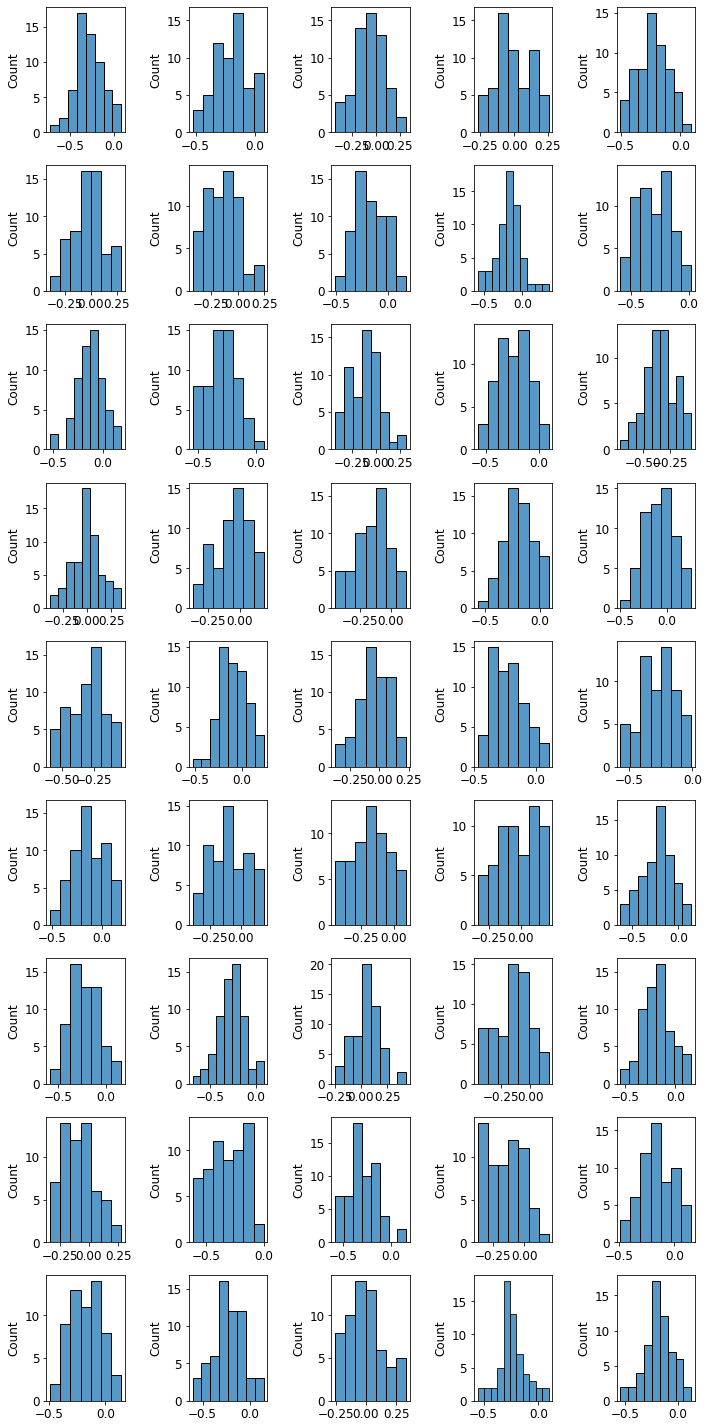

In [36]:
# test lin_model behavior

n_clusters = 45
n_obs = 60


# Hyperparameters
alpha_scale = 0.1
beta_scale = 0.1
sigma_shape = 2
sigma_scale = 4
# (1/scale)/(shape-1) = mean der inv gamma = erwartung für std 

# Hyperparameters - model specific
## Common effects model
theta_scale = 0.1


# Priors - model specific
## Null model
#theta_i = np.repeat(0, n_clusters)

## Common effects model
theta_i = np.repeat(np.random.normal(0, theta_scale), n_clusters)

# Priors - general
alpha_i = np.random.normal(0, alpha_scale, size=n_clusters) # Person-specific intercept
beta = np.random.normal(0, beta_scale) # Effect of factual truth of statement
sigma = 1/np.random.gamma(sigma_shape, sigma_scale) # random error variance
epsilon = np.random.normal(0, sigma, size=(n_clusters, n_obs))


# create obs vectors
t_j = np.repeat([0,1],n_obs/2) # truth status of statement j 
x_k = np.repeat([0,1,0,1],n_obs/4) # repetition condition (new=0 / old=1)

# generate data
lin_model = alpha_i[..., np.newaxis] + t_j*beta + x_k*theta_i[..., np.newaxis] + epsilon


# Plot dists within groups
print('theta_i mean:', round(np.mean(theta_i), 2)) 
print('alpha_i mean:', round(np.mean(alpha_i), 2))
print('alpha_i var:', round(np.var(alpha_i), 2))
print('beta:', round(beta, 2))
print('sigma:', round(sigma, 2))

fig, axarr = plt.subplots(9, 5, figsize=(10, 20))

for i in range(lin_model.shape[0]):
    sns.histplot(lin_model[i,:], ax = axarr.flat[i])

fig.tight_layout()

In [146]:
class TruthSimulator:
    
    def __init__(self):    
        pass
    
    def draw_from_prior(self, model_index, n_clusters, n_obs):
        """
        Draws parameter values from the specified prior distributions of the 
        hyperprior and the conditional prior.
        ----------
        
        Arguments:        
        model_index : int -- index of the model to be simulated from
        n_clusters : int -- number of higher order clusters that the observations are nested in
        """
        
        # Hyperparameters - general
        alpha_scale = 0.1
        beta_scale = 0.1
        sigma_shape = 2
        sigma_scale = 4
        
        # Hyperparameters - model specific
        ## Common effects model
        theta_scale = 0.1 
        
        if model_index == 0: # Null model
            theta_i = np.repeat(0, n_clusters)
            
        if model_index == 1: # Common-effect model 
            theta_i = np.repeat(np.random.normal(0, theta_scale), n_clusters)
            
        #if model_index == 2: # Positive-effects model
        #    #prior_nu = stats.truncnorm.rvs(loc=0, scale=np.sqrt(prior_g_nu), a=0, b=np.inf)
        #    theta_i = stats.truncnorm.rvs(loc=prior_nu, scale=1, a=-prior_nu, b=np.inf, size=n_clusters)
            
        #if model_index == 3: # Unconstrained model
        #    # g-prior for scale param
        #    rscale = 0.5
        #    prior_g_theta = 1/np.random.gamma(shape=1, scale=1)
        #    theta_i = np.random.normal(prior_nu, np.sqrt(prior_g_theta), size=n_clusters)
            
        # Priors - general
        alpha_i = np.random.normal(0, alpha_scale, size=n_clusters) # Person-specific intercept
        beta = np.random.normal(0, beta_scale) # Effect of factual truth of statement
        sigma = 1/np.random.gamma(sigma_shape, sigma_scale) # random error variance
        epsilon = np.random.normal(0, sigma, size=(n_clusters, n_obs))

        return alpha_i, beta, theta_i, sigma, epsilon
    
    def gen_from_likelihood(self, alpha_i, beta, theta_i, sigma, epsilon, n_clusters, n_obs):
        """
        Generates a single hierarchical dataset from the sampled parameter values.
        ----------
        
        Arguments: 
        params : list -- parameters sampled from prior
        n_clusters : int -- number of higher order clusters that the observations are nested in
        n_obs  : int -- number of observations per cluster
        """

        if n_obs % 4 == 0: # fixed vectors
            t_j = np.repeat([0,1],n_obs/2) # truth status of statement j 
            x_k = np.repeat([0,1,0,1],n_obs/4) # repetition condition (new=0 / old=1) 
        else:
            t_j = np.random.binomial(n=1, p=.5, size=n_obs) # truth status of statement j 
            x_k = np.random.binomial(n=1, p=.5, size=n_obs) # repetition condition (new=0 / old=1) 
        
        # Generate data from linear model
        X = alpha_i[..., np.newaxis] + t_j*beta + x_k*theta_i[..., np.newaxis] + epsilon
        
        # Optional: clip values smaller -1 and greater 1
        #X = np.clip(X, -1, 1)

        return X
    
    def generate_single(self, model_index, n_clusters, n_obs):
        """
        Generates a single hierarchical dataset utilizing the draw_from_prior and gen_from_likelihood functions.
        ----------
        
        Arguments:
        model_index : int -- index of the model to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        n_obs       : int -- number of observations per cluster
        --------
        
        Returns:
        numpy array of shape (n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        alpha_i, beta, theta_i, sigma, epsilon = self.draw_from_prior(model_index, n_clusters, n_obs)
        x_generated = self.gen_from_likelihood(alpha_i, beta, theta_i, sigma, epsilon, n_clusters, n_obs)
        return x_generated[...,np.newaxis]

In [91]:
class BinaryTruthSimulator:
    
    def __init__(self):    
        pass
    
    def draw_from_prior(self, model_index, n_clusters):
        """
        Draws parameter values from the specified prior distributions of the 
        hyperprior and the conditional prior.
        ----------
        
        Arguments:        
        model_index : int -- index of the model to be simulated from
        n_clusters : int -- number of higher order clusters that the observations are nested in
        """
        
        if model_index == 0: # Null model
            theta_i = np.repeat(0, n_clusters)
        
        else:
            # g-prior for location param
            prior_g_nu = 1/np.random.gamma(shape=1, scale=1)
            prior_nu = np.random.normal(0, np.sqrt(prior_g_nu))
            
        if model_index == 1: # Common-effect model 
            theta_i = np.repeat(prior_nu, n_clusters)
            
        #if model_index == 2: # Positive-effects model
        #    #prior_nu = stats.truncnorm.rvs(loc=0, scale=np.sqrt(prior_g_nu), a=0, b=np.inf)
        #    theta_i = stats.truncnorm.rvs(loc=prior_nu, scale=1, a=-prior_nu, b=np.inf, size=n_clusters)
            
        #if model_index == 3: # Unconstrained model
        #    # g-prior for scale param
        #    rscale = 0.5
        #    prior_g_theta = 1/np.random.gamma(shape=1, scale=1)
        #    theta_i = np.random.normal(prior_nu, np.sqrt(prior_g_theta), size=n_clusters)
            
        # Scale param for alpha_i: prior_g_alpha
        prior_g_alpha = 1/np.random.gamma(1,1)

        # Scale param for beta: prior_g_beta
        prior_g_beta = 1/np.random.gamma(1,1)
        
        # Final priors for linear model (additional to theta_i)
        mu = np.random.normal(0, 1) # Grand mean intercept / standard-normal instead of Jeffreys prior as we don't have sigma anymore
        #alpha_i = np.random.normal(0, prior_g_alpha, size=n_clusters) # Person-specific intercept
        alpha_i = np.repeat(0, n_clusters)
        #beta = np.random.normal(0, prior_g_beta) # Effect of factual truth of statement
        beta = np.random.normal(0,1)
        return mu, alpha_i, beta, theta_i
    
    def gen_from_likelihood(self, mu, alpha_i, beta, theta_i, n_clusters, n_obs):
        """
        Generates a single hierarchical dataset from the sampled parameter values.
        ----------
        
        Arguments: 
        params : list -- parameters sampled from prior
        n_clusters : int -- number of higher order clusters that the observations are nested in
        n_obs  : int -- number of observations per cluster
        """
        
        if n_obs % 4 == 0: # fixed vectors
            t_j = np.repeat([0,1],n_obs/2) # truth status of statement j 
            x_k = np.repeat([0,1,0,1],n_obs/4) # repetition condition (new=0 / old=1) 
        else:
            t_j = np.random.binomial(n=1, p=.5, size=n_obs) # truth status of statement j 
            x_k = np.random.binomial(n=1, p=.5, size=n_obs) # repetition condition (new=0 / old=1) 
        
        # Specify linear model
        lin_model = (mu + alpha_i)[..., np.newaxis] + t_j*beta + x_k*theta_i[..., np.newaxis]

        # Optional: surpress overflow and following true_divide warnings
        #np.seterr(over='ignore', invalid='ignore')
        
 
        # Obtain p
        p = 1/(1+np.exp(-lin_model))     
        #p = np.exp(lin_model)/(1+np.exp(lin_model))
        p = np.nan_to_num(p, nan=1)# replace nans stemming from overflow

        # Generate x
        X = np.random.binomial(n=1, p=p, size=(n_clusters,n_obs))
 
        return X
    
    def generate_single(self, model_index, n_clusters, n_obs):
        """
        Generates a single hierarchical dataset utilizing the draw_from_prior and gen_from_likelihood functions.
        ----------
        
        Arguments:
        model_index : int -- index of the model to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        n_obs       : int -- number of observations per cluster
        --------
        
        Returns:
        numpy array of shape (n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        mu, alpha_i, beta, theta_i = self.draw_from_prior(model_index, n_clusters)
        x_generated = self.gen_from_likelihood(mu, alpha_i, beta, theta_i, n_clusters, n_obs)
        return x_generated[...,np.newaxis]

In [71]:
class MainSimulator:
    
    def __init__(self, simulator):
        
        self.simulator = simulator
    
    def draw_from_model_prior(self, batch_size, n_models, model_prior):
        """
        Creates the sequence of models to be simulated from in the batch.
        ----------
        
        Arguments:
        batch_size     : int -- number of batches to be generated
        n_models       : int -- number of models to be simulated from
        model_prior    : list -- prior model probabilities
        --------
        
        Returns:
        array of shape (batch_size) - array of indices corresponding to the sampled model from p(M).
        """
        
        # create base list of model indices
        model_base_indices = [*range(n_models)]
        
        # uniform prior over model probabilities if no model prior given
        if model_prior == None:
            model_prior = [1/n_models] * n_models
        
        # generate sampling list of model indeces
        model_indices = np.random.choice(model_base_indices, size=batch_size, p=model_prior)
        return model_indices
    
    def simulate(self, batch_size, n_models, model_prior, 
                 n_clust_min=2, n_clust_max=100, n_obs_min=2, n_obs_max=200):
        """
        Simulates a batch of hierarchical datasets.
        ----------
        
        Arguments:
        batch_size     : int -- number of datasets to be generated per batch
        n_models       : int -- number of models to be simulated from
        model_prior    : list -- prior model probabilities
        n_clust_min    : int -- minimum number of clusters
        n_clust_max    : int -- maximum number of cluster
        n_obs_min      : int -- minimum number of observations
        n_obs_max      : int -- maximum number of observations
        --------
        
        Returns:
        dict of {'X' : array of shape (batch_size, n_clusters, n_obs, n_variables),  
                 'm' : array of shape (batch_size)}
        """
        # Draw K and N (drawn values apply for all datasets in the batch)
        n_clusters = np.random.randint(n_clust_min, n_clust_max+1)
        n_obs = np.random.randint(n_obs_min, n_obs_max+1)
        
        # Draw sampling list of model indices
        model_indices = self.draw_from_model_prior(batch_size, n_models, model_prior)
        
        # Prepare an array to hold simulations
        X_gen = np.zeros((batch_size, n_clusters, n_obs, 1), dtype=np.float32)
        
        for b in range(batch_size):
            X_gen[b] = self.simulator.generate_single(model_indices[b], n_clusters, n_obs)
               
        return {'X': X_gen, 'm': model_indices, 'n_clusters': n_clusters, 'n_obs': n_obs}
    
    def __call__(self, batch_size, n_models=2, model_prior=None, 
                 n_clust_min=2, n_clust_max=100, n_obs_min=2, n_obs_max=200):
        return self.simulate(batch_size, n_models, model_prior, n_clust_min, n_clust_max, n_obs_min, n_obs_max)

# Neural networks

## Invariant Module

In [13]:
class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, model_settings, pooler=tf.reduce_mean):
        """
        Creates an invariant function with mean pooling.
        ----------
        
        Arguments:
        model_settings : dict -- hyperparameter settings for the invariant module
        """
        
        super(InvariantModule, self).__init__()
        
        # Pre pooling network
        self.pre_pooling_dense = tf.keras.Sequential([tf.keras.layers.Dense(**model_settings['dense_inv_pre_pooling_args'])
                                                     for _ in range(model_settings['n_dense_inv'])])
        
        self.pooler = pooler
        
        # Post pooling network
        self.post_pooling_dense = tf.keras.Sequential([tf.keras.layers.Dense(**model_settings['dense_inv_post_pooling_args'])
                                                      for _ in range(model_settings['n_dense_inv'])])
        
            
    def call(self, x):
        """
        Transforms the input into an invariant representation.
        ----------
        
        Arguments:
        x : tf.Tensor of variable shape - 4-dimensional with (batch_size, n_clusters, n_obs, n_variables)
                                          or 3-dimensional with (batch_size, n_clusters, inv_embedding)
        --------
        
        Returns:
        out: tf.Tensor of variable shape - either 3-dimensional (when input is 4D) with (batch_size, n_clusters, inv_embedding)
                                           or 2-dimensional (when input is 3D) with (batch_size, inv_embedding)
        """
        
        # Embed input before pooling
        x_emb = self.pre_pooling_dense(x)
        
        # Get dimensionality of lowest exchangeable level before pooling and repeat
        # shape of rep_N is (batch_size, K, 1) or (batch_size, 1) depending on input dimensions
        log_N = np.log(x_emb.shape[-2])
        if len(x.shape) == 4:
            rep_N = np.repeat([log_N], x_emb.shape[0]*x_emb.shape[1]).reshape(x_emb.shape[0], x_emb.shape[1], 1)
        else:
            rep_N = np.repeat([log_N], x_emb.shape[0])[:, np.newaxis]
        rep_N = tf.convert_to_tensor(rep_N, dtype=tf.float32)
        
        # Perform mean pooling, shape of pooled is (batch_size, K, dense_out)
        pooled = self.pooler(x_emb, axis=-2) # always reduce dimensionality of the lowest exchangable data level 
        pooled = tf.concat((pooled, rep_N), axis=-1) # concatenate to preserve info about N
        
        # Increase representational power
        out = self.post_pooling_dense(pooled)
        return out

In [14]:
class HierarchicalNetwork(tf.keras.Model):
    """
    Implements a network that is able to process hierarchical data.
    """
    
    def __init__(self, model_settings):
        """
        Creates a hierarchical Network consisting of two stacked invariant modules.
        ----------
        
        Arguments:
        model_settings : dict -- hyperparameter settings for the invariant module
        """
        
        super(HierarchicalNetwork, self).__init__()
        
        self.inv_4d = InvariantModule(model_settings)
        self.inv_3d = InvariantModule(model_settings)
        
        # The final layer to output model evidences
        if model_settings['n_models'] == 2: # Binary Classification
            n_out = 1 
            act_out = "sigmoid"
        else:
            n_out = model_settings['n_models']
            act_out = "softmax"
        self.model_probs_layer = tf.keras.layers.Dense(n_out, activation=act_out)
        
    def call(self, x):
        """
        Transforms the 4-dimensional input into model probabilities.
        ----------
        
        Arguments:
        x : tf.Tensor of shape (batch_size, n_clusters, n_obs, n_variables)
        --------
        
        Returns:
        model_probs : tf.Tensor of shape (batch_size, n_models) -- the model posterior probabilities
        """
        
        x_3d = self.inv_4d(x)
        x_2d = self.inv_3d(x_3d)
        model_probs = self.model_probs_layer(x_2d)
        return model_probs

### Experiments

#### Network settings

In [15]:
# Network settings for all experiments
model_settings = {
    'n_models'                    : 2,
    'dense_inv_pre_pooling_args'  : dict(units=4, activation='elu', kernel_initializer='glorot_normal'),
    'dense_inv_post_pooling_args' : dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'dense_equiv_args'            : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
    'n_dense_inv'                 : 2,
    'n_dense_equiv'               : 2
}

#### Helper function for online training

In [16]:
def train_online(model, optimizer, simulator, loss_fun, iterations, epochs, batch_size, n_models=2):
    """
    Trains a Hierarchical Network.
    ----------
        
    Arguments:
    model      : the hierarchical model to be trained
    optimizer  : the algorithm that optimizes the neural network
    simulator  : the simulator that generates data from the hierarchical models
    loss_fun   : the loss function that shall be minimized during training
    iterations : int -- number of iterations per epoch
    epochs     : int -- number of epochs 
    batch_size : int -- batch_size for training
    --------
        
    Returns:
    losses : numpy array of shape (iterations * epochs)
    """
    
    losses = dict()
    # For loop through epochs
    for ep in range(1, epochs+1):
        # Init losses for this epoch
        losses[ep] = []
        with tqdm(total=iterations, desc='Training epoch {}'.format(ep)) as p_bar:
            for it in range(1, iterations+1):
                # Simulate batch of datasets
                batch = simulator(batch_size)
                with tf.GradientTape() as tape:
                    # Forward pass
                    if n_models == 2:
                        preds_m = model(batch["X"])[:,0] # [:,0] to match shape of predictions with true indices
                        batch_m = batch["m"]
                    else:
                        preds_m = model(batch["X"])
                        batch_m = tf.one_hot(batch["m"], depth=n_models)
                    loss = loss_fun(batch_m, preds_m)
                # One step backprop
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                # Store losses
                losses[ep].append(loss)
                
                # Update progess bar
                p_bar.set_postfix_str("Epoch {0},Iteration {1},Loss: {2:.3f},Running Loss: {3:.3f}"
                                          .format(ep, it + 1, loss, np.mean(losses[ep])))
                p_bar.update(1)
    
    return losses

#### Training with fixed number of clusters and observations

In [135]:
# Setup
# Calibration experiments

n_clust_min = 30
n_clust_max = 30
n_obs_min = 50
n_obs_max = 50

In [ ]:
# Setup
# Bridge Sampling comparison

n_clust_min = 53
n_clust_max = 53
n_obs_min = 94
n_obs_max = 94

In [136]:
batch_size = 32
iterations = 1000
epochs = 10

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
simulator = partial(MainSimulator(HierarchicalNormalSimulator()), 
                    n_clust_min=n_clust_min, n_clust_max=n_clust_max, 
                    n_obs_min=n_obs_min, n_obs_max=n_obs_max)
loss_fun = tf.losses.BinaryCrossentropy()
model = HierarchicalNetwork(model_settings)

In [137]:
%%time

training_time_start = perf_counter()
losses = train_online(model, optimizer, simulator, loss_fun, iterations, epochs, batch_size)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 2min 50s


In [153]:
# Validation
n_val = 5000
val_data = simulator(n_val)

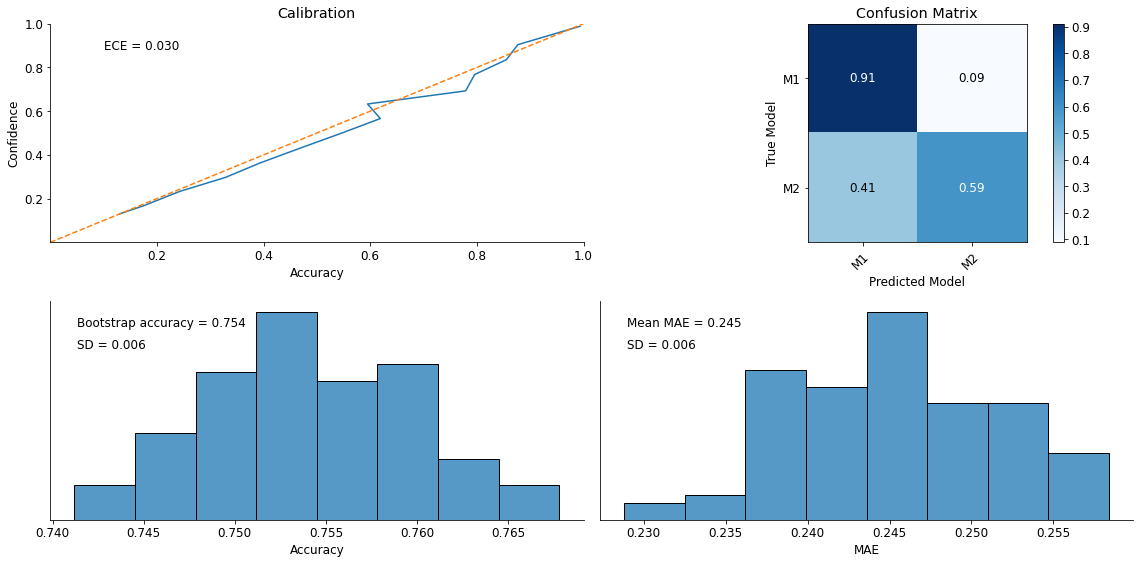

In [154]:
perf_tester(model, val_data, n_cal_bins=15)

0.03006699884131583


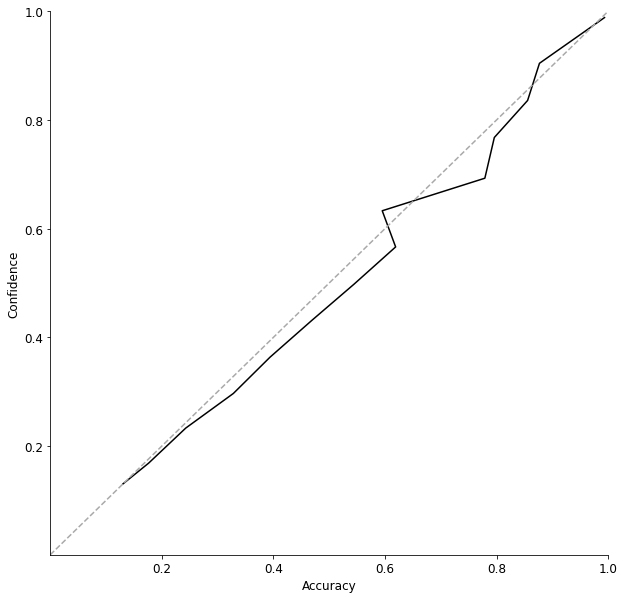

In [155]:
# Plotting for thesis
probs = model(val_data["X"])
true_models = val_data["m"]

fig, ax = plt.subplots(figsize=(10,10))

prob_true, prob_pred = calibration_curve(true_models, probs, n_bins=15)
cal_err = np.mean(np.abs(prob_true - prob_pred))
print(cal_err)
ax.plot(prob_true, prob_pred, color='black')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='darkgrey')
ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xlabel('Accuracy')
ax.set_ylabel('Confidence')
sns.despine(ax=ax)

In [157]:
cal_err

0.03006699884131583

#### Training with fixed numbers of clusters and variable number of observations

In [64]:
# Experimental variables setup

n_clust_min = 30
n_clust_max =30
n_obs_min = 1
n_obs_max = 200

In [79]:
# NN setup
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
simulator = partial(MainSimulator(HierarchicalNormalSimulator()), 
                    n_clust_min=n_clust_min, n_clust_max=n_clust_max, 
                    n_obs_min=n_obs_min, n_obs_max=n_obs_max)
loss_fun = tf.losses.BinaryCrossentropy()
model = HierarchicalNetwork(model_settings)

In [96]:
%%time
losses = train_online(model, optimizer, simulator, loss_fun, iterations, epochs, batch_size)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 4min 3s


In [97]:
# Validation setup
n_val_per_setting = 5000
simulator = MainSimulator(HierarchicalNormalSimulator())

In [98]:
# Generate data for each setting

# Create list of validation data
val_data = []
for i in range(n_obs_min, n_obs_max+1):
    sim_data = simulator(n_val_per_setting, n_clust_min=n_clust_min, n_clust_max=n_clust_max, 
                         n_obs_min=i, n_obs_max=i)
    val_data.append(sim_data)
    if i%10 == 0:
        print('Iteration {} finished'.format(i))

Iteration 10 finished
Iteration 20 finished
Iteration 30 finished
Iteration 40 finished
Iteration 50 finished
Iteration 60 finished
Iteration 70 finished
Iteration 80 finished
Iteration 90 finished
Iteration 100 finished
Iteration 110 finished
Iteration 120 finished
Iteration 130 finished
Iteration 140 finished
Iteration 150 finished
Iteration 160 finished
Iteration 170 finished
Iteration 180 finished
Iteration 190 finished
Iteration 200 finished


Wall time: 10.5 s


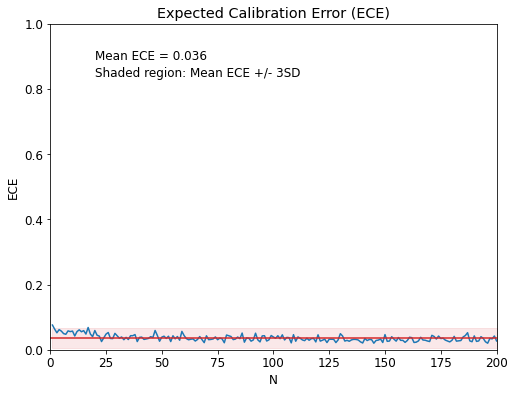

In [99]:
%%time

perf_tester_over_obs(model, val_data, n_obs_min, n_obs_max)

In [133]:
# Plotting for thesis

def plot_eces_over_obs_thesis(m_true, m_pred, n_obs_min, n_obs_max, n_bins):
    """Helper function to plot ece as a function of N."""

    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    n_obs_points = np.arange(n_obs_min, n_obs_max+1)
    prob_true, prob_pred, cal_err = ([] for i in range(3))
    
    for i in n_obs_points-1:
        prob_true_i, prob_pred_i = calibration_curve(m_true[i], m_pred[i], n_bins=n_bins)
        prob_true.append(prob_true_i)
        prob_pred.append(prob_pred_i)
        cal_err_i = np.mean(np.abs(prob_true[i] - prob_pred[i]))
        cal_err.append(cal_err_i)
    ax.plot(n_obs_points, cal_err, color='black')
    mean_ece = np.mean(cal_err)
    print(mean_ece)
    #sd_ece = np.std(cal_err)
    plt.axhline(y=mean_ece, linestyle='--', color='darkgrey')
    #plt.fill_between(n_obs_points, mean_ece-3*sd_ece, mean_ece+3*sd_ece, 
    #                 color='tab:red', alpha=0.1)
    ax.set_xlim([0, n_obs_max])
    ax.set_ylim([0, 1])
    ax.set_xlabel('N')
    ax.set_ylabel('ECE')
    print(cal_err[:5])

def perf_tester_over_obs_thesis(model, val_data, n_obs_min, n_obs_max, n_bootstrap=100, n_cal_bins=15):
    """Utility function to test the performance of the model."""
    
    # Compute model predictions in chunks so GPU memory does not blow-up
    m_soft, m_hard, m_true = ([] for i in range(3))
    
    for i in range(n_obs_min-1, n_obs_max):
        m_soft_i = tf.concat([model(x_chunk) for x_chunk in tf.split(val_data[i]['X'], 5)], axis=0).numpy()
        m_soft.append(m_soft_i)
        m_hard_i = (m_soft[i] > 0.5).astype(np.int32)
        m_hard.append(m_hard_i)
        m_true_i = val_data[i]['m']
        m_true.append(m_true_i)

    # Plot stuff
    plot_eces_over_obsa(m_true, m_soft, n_obs_min, n_obs_max, n_cal_bins)

0.03636013676129997
[0.07591066216353166, 0.06329931438270679, 0.05220302824349208, 0.0618628080087027, 0.057252421242055186]


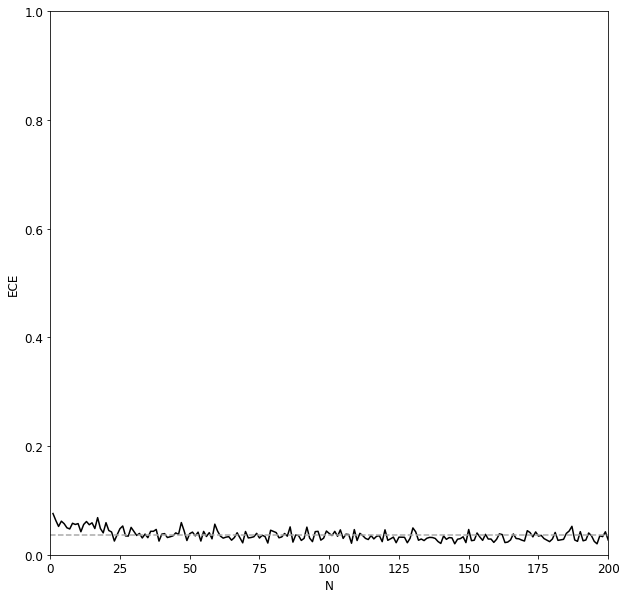

In [134]:
perf_tester_over_obs_thesis(model, val_data, n_obs_min, n_obs_max)

#### Training with variable numbers of clusters and observations

In [165]:
# Setup
# Calibration experiments

n_clust_min = 1
n_clust_max = 50
n_obs_min = 1
n_obs_max = 200

In [13]:
# Setup
# Bridge Sampling comparison
n_clust_min = 1
n_clust_max = 100
n_obs_min = 50
n_obs_max = 150

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
simulator = partial(MainSimulator(HierarchicalNormalSimulator()), 
                    n_clust_min=n_clust_min, n_clust_max=n_clust_max, 
                    n_obs_min=n_obs_min, n_obs_max=n_obs_max)
loss_fun = tf.losses.BinaryCrossentropy()
model = HierarchicalNetwork(model_settings)

In [15]:
%%time

training_time_start = perf_counter()
losses = train_online(model, optimizer, simulator, loss_fun, iterations, epochs, batch_size)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 11min 42s


In [18]:
# Validation setup
n_val_per_setting = 5000
simulator = MainSimulator(HierarchicalNormalSimulator())

In [ ]:
# Compute ECEs
ece_means = compute_eces_variable(model, simulator, n_val_per_setting, n_clust_min, n_clust_max, n_obs_min, n_obs_max)

In [119]:
# Export ECE data
#local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
#filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_variable_clusters_variable_obs_eces_20,000_steps')
#val_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'Validation_datasets')
#np.save(os.path.join(val_folder, filename), ece_means)

# Load ECE data
val_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'Validation_datasets')
ece_filename = "2021_07_13___12_26_variable_clusters_variable_obs_eces.npy"
ece_means = np.load(os.path.join(val_folder, ece_filename))

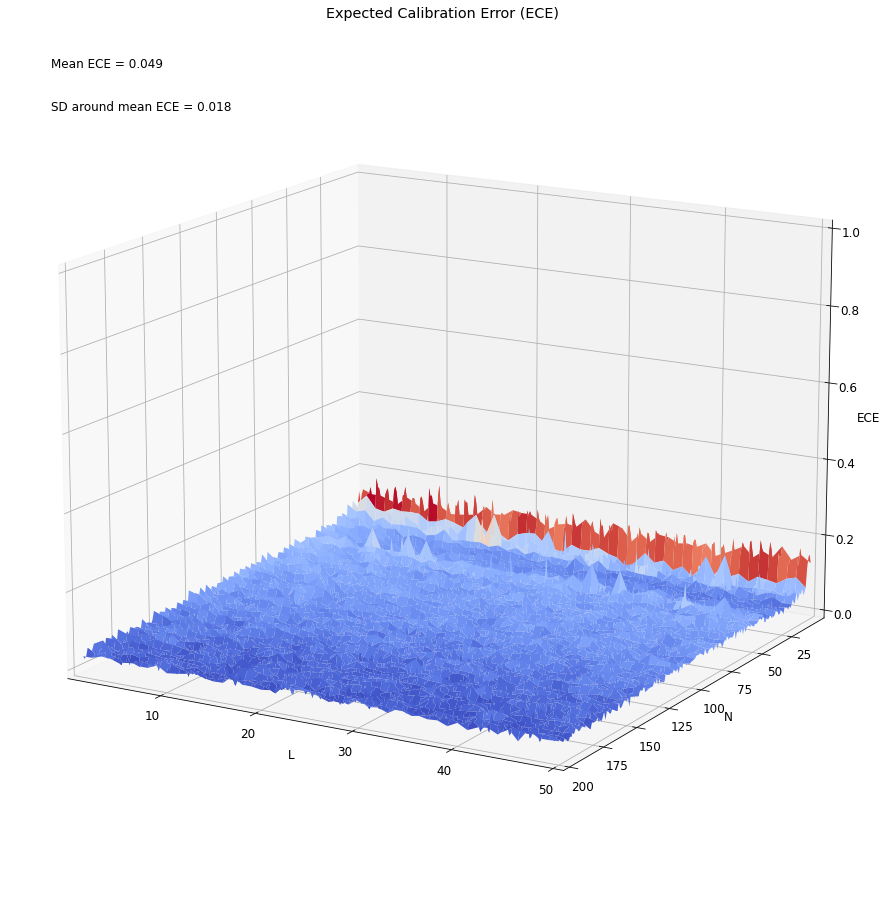

In [181]:
# Plot ECEs
plot_eces_variable(ece_means, n_val_per_setting, n_clust_min, n_clust_max, n_obs_min, n_obs_max)

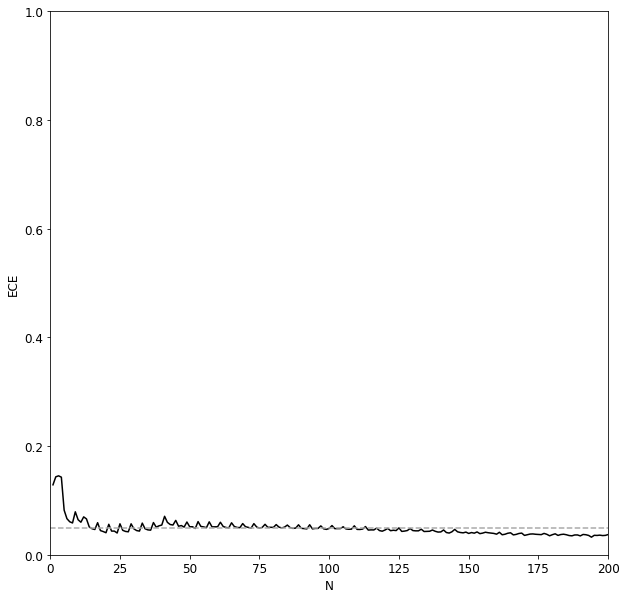

In [164]:
# Plot ECEs only over N (averaged over L)

# Average over L in order to plot over N
ece_means_reshaped = np.reshape(ece_means, (-1, n_clust_max)) # reshape into (#clusters, #observations)
ece_means_over_N = np.mean(ece_means_reshaped, axis = 1)
ece_means_over_N_sd = np.std(ece_means_reshaped, axis = 1)

# Plot
plot_eces_means_over_obs(ece_means_over_N, ece_means_over_N_sd, n_obs_min, n_obs_max)

In [184]:
ece_means_over_N[:5]

array([0.12874977, 0.14344279, 0.14526232, 0.14284047, 0.082071  ])

In [100]:
# Amortized vs non amortized NN for small N's
# Does the problematic behavior of the variable net stem from an Amortization Gap?
print('Mean ECE over all L (more stable) = {}'.format(ece_means_over_N[1:5]))
print('Mean ECE for L=30 (more comparable) = {}'.format(ece_means_reshaped[1:5,29]))
pd.DataFrame([['2','3','4','5'],[0.181, 0.161, 0.185, 0.131],
             [0.035,0.031,0.030,0.025]], index = ['N', 'Amortized NN', 'Non-amortized NN']).transpose()


Mean ECE over all L (more stable) = [0.18186985 0.16163864 0.18543966 0.13194074]
Mean ECE for L=30 (more comparable) = [0.28357073 0.09129752 0.20401547 0.19677951]


,N,Amortized NN,Non-amortized NN
0,2,0.181,0.035
1,3,0.161,0.031
2,4,0.185,0.03
3,5,0.131,0.025


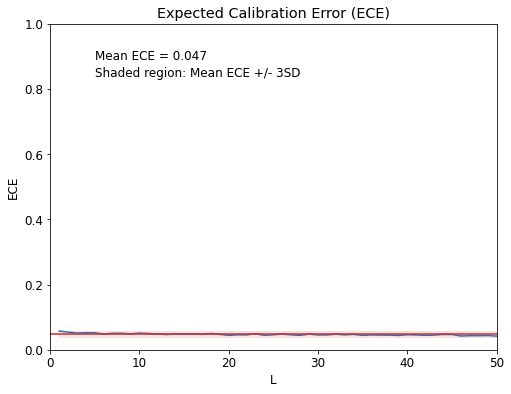

In [64]:
# Inspect pattern over L (averaged over N)
ece_means_reshaped = np.reshape(ece_means, (-1, n_clust_max)) # reshape into (#clusters, #observations)
ece_means_over_N = np.mean(ece_means_reshaped, axis = 0)
ece_means_over_N_sd = np.std(ece_means_reshaped, axis = 0)

# Plot
plot_eces_means_over_obs(ece_means_over_N, ece_means_over_N_sd, n_clust_min, n_clust_max, xlabel = 'L')

# Bridge Sampling Comparison - Bayes Factor Approximation

## Generation of the datasets

In [16]:
np.random.seed(42)

simulator = MainSimulator(HierarchicalNormalSimulator())

test_data_bf = simulator(100)
test_data_bf_true_indices = test_data_bf["m"]
test_data_bf_datasets = test_data_bf["X"]

print('Shape of the simulated datasets (batch_size, n_clusters, n_obs, n_variables): {}'.format(test_data_bf_datasets.shape))

Shape of the simulated datasets (batch_size, n_clusters, n_obs, n_variables): (100, 53, 94, 1)


In [37]:
# save datasets
#np.save('test_data_bf', test_data_bf)
#np.save('test_data_bf_true_indices', test_data_bf_true_indices)
#np.save('test_data_bf_datasets', test_data_bf_datasets)

## Bayes Factor computation by trained NN

In [17]:
def get_preds_and_bfs(model, data, training_time_start, training_time_stop):
    """ Writes model predictions and resulting Bayes Factors for a given 
    array of datasets into a pandas DataFrame. 
    """

    dataset = np.arange(1,test_data_bf["X"].shape[0]+1)
    true_model = data["m"]

    # Predict
    inference_time_start = perf_counter()
    m1_prob = np.array(model(test_data_bf["X"]), dtype = np.longdouble)
    inference_time_stop = perf_counter()
    m0_prob = 1 - m1_prob
    selected_model = (m1_prob > 0.5)

    # Bayes Factors
    bayes_factor = m1_prob / m0_prob
    
    # Times
    training_time = np.repeat((training_time_stop-training_time_start), 100)
    inference_time = np.repeat((inference_time_stop-inference_time_start), 100)
    
    # Final epoch mean loss
    final_epoch_loss = np.repeat(np.mean(losses[10]), 100)

    # Create DataFrame
    vals = np.c_[dataset, true_model, m0_prob, m1_prob, selected_model, bayes_factor,
                 training_time, inference_time, final_epoch_loss]
    names = ['dataset', 'true_model', 'm0_prob', 'm1_prob', 'selected_model', 'bayes_factor',
             'training_time', 'inference_time', 'final_epoch_loss']
    df = pd.DataFrame(vals, columns = names)
    df[["dataset", "true_model", "selected_model"]] = df[["dataset", "true_model", "selected_model"]].astype(int)
    
    return df

In [18]:
comparison_results = get_preds_and_bfs(model, test_data_bf, training_time_start, training_time_stop)
comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.854759,0.145241,0,0.169920,702.230798,0.183092,0.451387
1,2,1,0.000256,0.999744,1,3900.678140,702.230798,0.183092,0.451387
2,3,1,0.417225,0.582775,1,1.396788,702.230798,0.183092,0.451387
3,4,0,0.591402,0.408598,0,0.690898,702.230798,0.183092,0.451387
4,5,0,0.611641,0.388359,0,0.634947,702.230798,0.183092,0.451387


In [170]:
# Export experimental results
# FIXED VARIANT
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_BF_NN_comp')
comparison_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'BF_approximation_comparison')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)

In [19]:
# Export experimental results
# VARIABLE VARIANT
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_BF_NN_variable_comp')
comparison_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'BF_approximation_comparison')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)

# Truth effect example

## Network Training

In [142]:
# Setup

n_clust_min = 45
n_clust_max = 45
n_obs_min = 100
n_obs_max = 100

n_models = 2

model_settings = {
    'n_models'                    : n_models,
    'dense_inv_pre_pooling_args'  : dict(units=4, activation='elu', kernel_initializer='glorot_normal'),
    'dense_inv_post_pooling_args' : dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'dense_equiv_args'            : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
    'n_dense_inv'                 : 3,
    'n_dense_equiv'               : 2
}

batch_size = 32
iterations = 1000
epochs = 10

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
simulator = partial(MainSimulator(TruthSimulator()), n_models=n_models, 
                    n_clust_min=n_clust_min, n_clust_max=n_clust_max, 
                    n_obs_min=n_obs_min, n_obs_max=n_obs_max)
if n_models == 2:
    loss_fun = tf.losses.BinaryCrossentropy()
else:
    loss_fun = tf.losses.CategoricalCrossentropy()
model = HierarchicalNetwork(model_settings)

In [143]:
%%time

# Training
losses = train_online(model, optimizer, simulator, loss_fun, iterations, epochs, batch_size, n_models)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 4min 40s


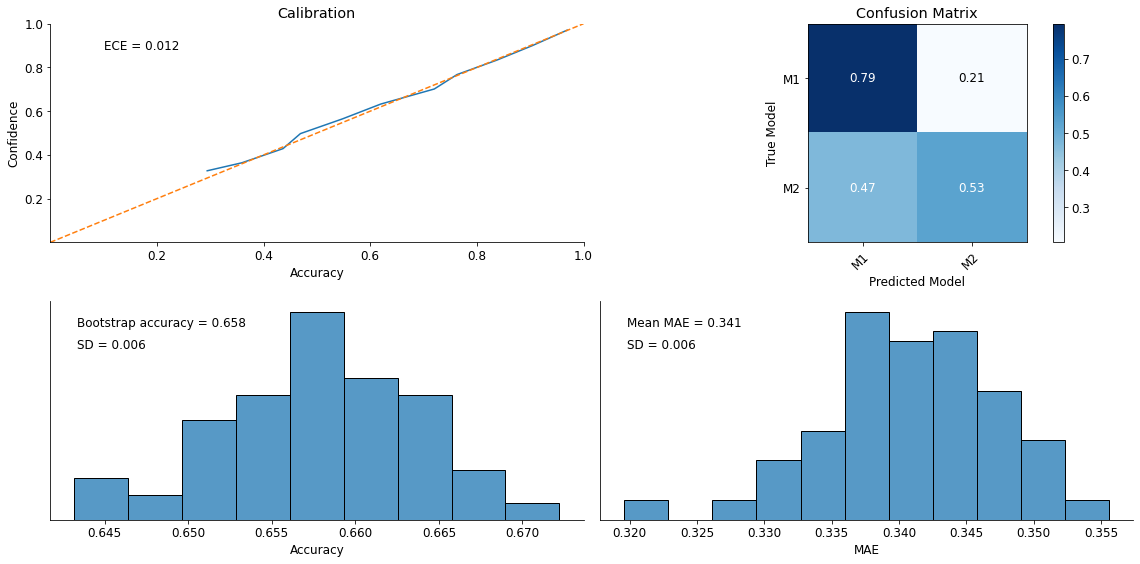

In [147]:
# Validation
n_val = 5000
val_data = simulator(n_val)
probs = model(val_data["X"])

if n_models == 2:
    rounded_predictions = np.array(tf.cast(probs > 0.5, tf.int32))
    true_models = val_data["m"]
else:
    rounded_predictions = tf.argmax(probs, axis=1)
    true_models = tf.one_hot(val_data["m"], depth=n_models)
    
if n_models == 2:
    perf_tester(model, val_data, n_cal_bins=15)

In [80]:
accuracy = tf.reduce_sum(tf.cast(rounded_predictions == val_data["m"], tf.float32))/5000
mae = mean_absolute_error(true_models,probs)
print('Accuracy = {}, MAE = {}'.format(accuracy, mae))

Accuracy = 2545.0, MAE = 0.49968858639001845


<AxesSubplot:>

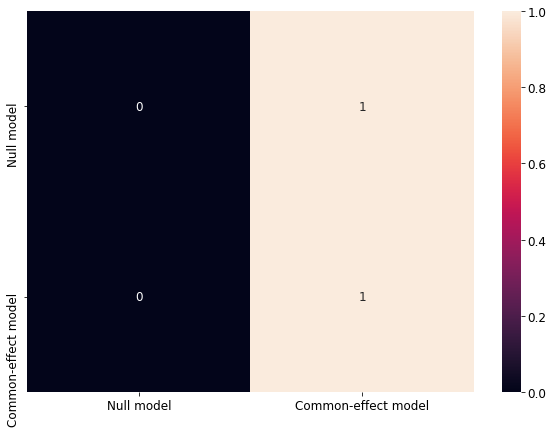

In [81]:
# confusion matrix for n_models > 2

cm = confusion_matrix(val_data["m"], rounded_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

model_names = ['Null model',
               'Common-effect model',
               'Positive-effects model',
               'Unconstrained model',]
df_cm = pd.DataFrame(cm, index = model_names[0:n_models], columns = model_names[0:n_models])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

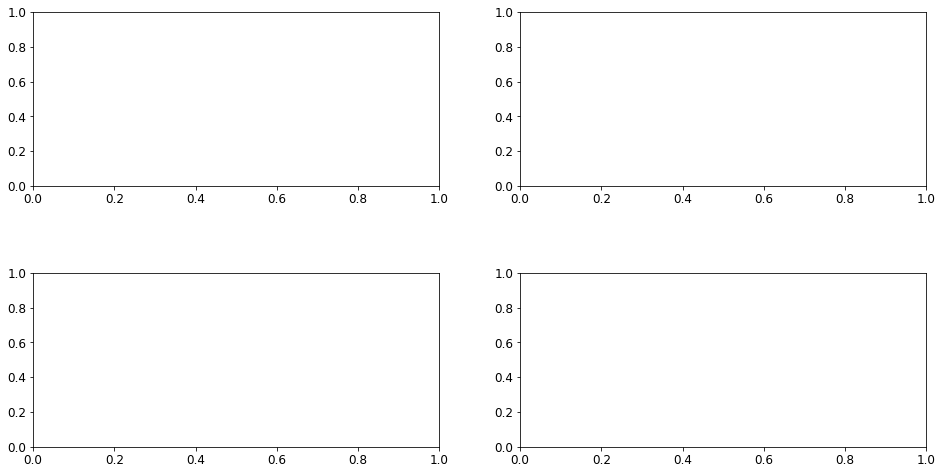

In [149]:
# Calibration Curves for n_models > 2

fig, axarr = plt.subplots(2, 2, figsize=(16, 8))
n_cal_bins = 15
plt.subplots_adjust(hspace = .5)
pos1 = [0,0,1,1]
pos2 = [0,1,0,1]
titles = ['Calibration: Null model',
          'Calibration: Common-effect model',
          'Calibration: Positive-effects model',
          'Calibration: Unconstrained model',]

for m in range(n_models):
    m_true = true_models[:,m]
    m_soft = probs[:,m]
    plot_calibration_curve(m_true, m_soft, 10, 
                           axarr[pos1[m], pos2[m]], title=titles[m])

## Application to empirical dataset

In [31]:
truth_file = os.path.join(os.path.dirname(os.getcwd()),
                          'data', 'Truth_effect_example', 'te_binary.csv')

truth_data = pd.read_csv(truth_file)

In [32]:
truth_data.head()

,sub,status,repetition,resp,rt
0,2,False,True,1,7551
1,2,False,True,0,2565
2,2,False,True,0,3553
3,2,False,True,0,4244
4,2,False,True,0,4273


In [33]:
# Reshape data into expected NN input
truth_X_reshaped = np.reshape(np.array(truth_data["resp"]), (45, 60)) # reshape into nested arrays
truth_X = truth_X_reshaped[...,np.newaxis][np.newaxis,...] # match dimensionality with expected input
print(truth_X.shape)

# Check if reshaping was correct by comparing person means
np.array(truth_data.groupby("sub")["resp"].mean()) == np.mean(truth_X_reshaped, axis=1)

(1, 45, 60, 1)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [46]:
# Obtain model probabilities
truth_model_probs = model(truth_X)
truth_model_probs

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.42019328, 0.08701203, 0.43205515, 0.06073955]], dtype=float32)>

In [47]:
print('Null model: {}'.format(truth_model_probs[0][0]))
print('Common-effect model: {}'.format(truth_model_probs[0][1]))
print('Positive-effects model: {}'.format(truth_model_probs[0][2]))
print('Unconstrained model: {}'.format(truth_model_probs[0][3]))

Null model: 0.42019328474998474
Common-effect model: 0.08701203018426895
Positive-effects model: 0.43205514550209045
Unconstrained model: 0.06073954701423645
